<a href="https://colab.research.google.com/github/R3gm/Colab-resources/blob/main/wav2vec2_transcript_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yt-dlp transformers pydub youtube_transcript_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Long-form audio transcription using Hugging Face Transformers
Source: https://github.com/machinelearnear/long-audio-transcription-spanish

In [ ]:
!python --version

Python 3.10.11


In [ ]:
import time
from os.path import exists as path_exists
from pathlib import Path

In [ ]:
if not path_exists('transcripts'):
    !mkdir transcripts

## Download audio from YouTube video

In [ ]:
YouTubeID = 'g_9rPvbENUw' 
OutputFile = 'test_audio_youtube.m4a'

In [ ]:
if not path_exists(OutputFile):
    !yt-dlp -o $OutputFile $YouTubeID --extract-audio --restrict-filenames -f 'bestaudio[ext=m4a]'

[youtube] Extracting URL: g_9rPvbENUw
[youtube] g_9rPvbENUw: Downloading webpage
[youtube] g_9rPvbENUw: Downloading android player API JSON
[youtube] g_9rPvbENUw: Downloading MPD manifest
[info] g_9rPvbENUw: Downloading 1 format(s): 140
[dashsegments] Total fragments: 1
[download] Destination: test_audio_youtube.m4a
[download] 100% of    1.06MiB in 00:00:00 at 1.66MiB/s
[FixupM4a] Correcting container of "test_audio_youtube.m4a"
[ExtractAudio] Not converting audio test_audio_youtube.m4a; the file is already in a common audio format


## End to End Automatic Speech Recognition

In [ ]:
model_name = "jonatasgrosman/wav2vec2-xls-r-1b-spanish"

In [ ]:
def save_to_file(transcript, text=None):
    with open(f'transcripts/transcribed_speech_{text}.txt', "w") as f:
        f.write(transcript)

### Option A: Process long audio file directly with `Pipelines`

In [ ]:
import librosa
from transformers import pipeline

In [ ]:
pipe = pipeline(model=model_name)

Could not load the `decoder` for jonatasgrosman/wav2vec2-xls-r-1b-spanish. Defaulting to raw CTC. Error: No module named 'kenlm'
Try to install `kenlm`: `pip install kenlm
Try to install `pyctcdecode`: `pip install pyctcdecode


In [ ]:
speech, sample_rate = librosa.load(OutputFile,sr=16000)
speech, sample_rate

<ipython-input-11-433b7f699e7f>:1: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, sample_rate = librosa.load(OutputFile,sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 16000)

In [ ]:
stime = time.time()
transcript = pipe(speech, chunk_length_s=10, stride_length_s=(4,2))
print(f'total time: {time.time()-stime:.2f} seconds')

total time: 345.70 seconds


In [ ]:
print(transcript['text'])
save_to_file(transcript['text'],text='hf_pipelines')

tardes nos encontramos con jeffer quees el de mantenimiento y puesél nos va a responder algunas preguntas primero cuáles son las áreas más contaminadas por residuos sólidos o paquetes que has visto en el colegio puaquí en el colegio p tenemos cincpuntos ecológicos pero más que todo se presenta escontaminación en las zonas verdes aproximadamente cantidares de basuras recolectas acá se hace recolección de basura se hace lunes miércoles y viernes paso menos de encantidad npor lo menos trecientokilos de basura y cuál consideras que es el residuo plástico que más abunda por lo general son botellas esos dice recoen cantidad y paquetes de papa y así listo muchísimas gracias portucolabras


### Option B: Split audio files in chunks by timestamp (`PyDub`)

In [ ]:
import torch
import pydub
import array
import numpy as np
from pydub.utils import mediainfo
from pydub import AudioSegment
from pydub.utils import get_array_type

In [ ]:
pydub_speech = pydub.AudioSegment.from_file(OutputFile)

In [ ]:
pydub_speech[:15*1000] # miliseconds

In [ ]:
def audio_resampler(sound, sample_rate=16000):
    sound = sound.set_frame_rate(sample_rate)
    left = sound.split_to_mono()[0]
    bit_depth = left.sample_width * 8
    array_type = pydub.utils.get_array_type(bit_depth)
    numeric_array = np.array(array.array(array_type, left._data))
    
    return np.asarray(numeric_array,dtype=np.double), sample_rate

In [ ]:
speech, sample_rate = audio_resampler(pydub_speech)

In [ ]:
transcript = ''
for chunk in np.array_split(speech,len(speech)/sample_rate/30)[:2]: # split every 30 seconds
    output = pipe(chunk)
    transcript = transcript + ' ' + output['text']
    print(output)
    
transcript = transcript.strip()

{'text': 'tardesnos encontramos con yefer quees el de mantenimiento y pues él nos va a responder a algunas preguntas primero cuáles son las áreas más contaminadas por residuos sólios o paquetes que has visto en el colegio pues aquí en el colegio pues tenemos cinco puntos decológicospero más que todo se presenta escontaminación en las zonas verdes'}
{'text': 'aproximadamente cuenta cantidades de basuras recolectas acá se hace recolección de basura se haceen lunes miércoles y viernes paso menos dencantidad son porlo menos trescientos kilos de basura y cuál consideras que es el residuo plástico que más abunda por lo general son botellas esto sí ce recoehen cantidad y paquetes de papa y ase listo muchísimasgracias tup'}


In [ ]:
print(transcript)
save_to_file(transcript,text='pydub_timestamps')

tardesnos encontramos con yefer quees el de mantenimiento y pues él nos va a responder a algunas preguntas primero cuáles son las áreas más contaminadas por residuos sólios o paquetes que has visto en el colegio pues aquí en el colegio pues tenemos cinco puntos decológicospero más que todo se presenta escontaminación en las zonas verdes aproximadamente cuenta cantidades de basuras recolectas acá se hace recolección de basura se haceen lunes miércoles y viernes paso menos dencantidad son porlo menos trescientos kilos de basura y cuál consideras que es el residuo plástico que más abunda por lo general son botellas esto sí ce recoehen cantidad y paquetes de papa y ase listo muchísimasgracias tup


### Option C: Split audio files based on silence detection (`Librosa`/`PyDub`)

(1) `Librosa`

In [ ]:
import librosa
from librosa import display

import matplotlib.pyplot as plt

In [ ]:
speech, sample_rate = librosa.load(OutputFile,sr=16000)

<ipython-input-22-85d6196ecad7>:1: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, sample_rate = librosa.load(OutputFile,sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


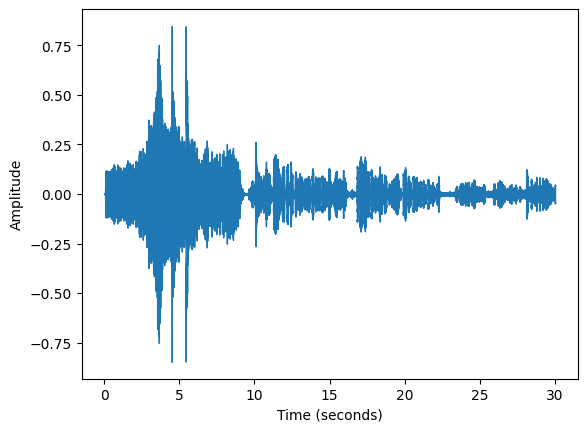

In [ ]:
plt.figure()
librosa.display.waveshow(y=speech[:30*sample_rate], sr=sample_rate) # first 30 seconds
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
non_mute_sections_in_speech = librosa.effects.split(speech,top_db=50)
non_mute_sections_in_speech

array([[    512,  151552],
       [ 152576, 1103041]])

In [ ]:
transcript = ''
for chunk in non_mute_sections_in_speech[:6]:
    speech_chunk = speech[chunk[0]:chunk[1]]
    output = pipe(speech_chunk)
    transcript = transcript + ' ' + output['text']
    print(output)
    
transcript = transcript.strip()

{'text': 'upimima'}
{'text': 'serdesnos encontramos con yefer que es el de mantenimiento y puesél nos va a responder algunas preguntas primero cuáles son las áreas más contaminadas por residuos sólidos o paquetes que has visto en el colegio pues aquí en el colegio putenemos cinco puntos ecológicos peromás que todo se presentacontaminación en las zonas verdes aproximadamente cuanta cantidad de basuras recolectas acá se hace recolección de basurase haclunes miércoles y viernes paso menos encantidad son porlo menos recientocilode basura ycuál consideras que es el residuo plástico que más abunda por lo general son botellas estos dice recoeden cantidad y paquetes de papa y has listo mu'}


In [ ]:
print(transcript)
save_to_file(transcript,text='librosa_silence')

upimima serdesnos encontramos con yefer que es el de mantenimiento y puesél nos va a responder algunas preguntas primero cuáles son las áreas más contaminadas por residuos sólidos o paquetes que has visto en el colegio pues aquí en el colegio putenemos cinco puntos ecológicos peromás que todo se presentacontaminación en las zonas verdes aproximadamente cuanta cantidad de basuras recolectas acá se hace recolección de basurase haclunes miércoles y viernes paso menos encantidad son porlo menos recientocilode basura ycuál consideras que es el residuo plástico que más abunda por lo general son botellas estos dice recoeden cantidad y paquetes de papa y has listo mu


(2) `PyDub` # Good option

In [ ]:
pydub_speech = pydub.AudioSegment.from_file(OutputFile)

In [ ]:
chunks = pydub.silence.split_on_silence(
    pydub_speech,
    min_silence_len = 500,
    silence_thresh = pydub_speech.dBFS - 16,
    keep_silence = 250, # optional
)

# minimum chunk length
target_length = 20 * 1000 # 20 seconds

output_chunks = [chunks[0]]
for chunk in chunks[1:]:
    if len(output_chunks[-1]) < target_length:
        output_chunks[-1] += chunk
    else:
        # if the last output chunk
        # is longer than the target length,
        # we can start a new one
        output_chunks.append(chunk)

In [ ]:
output_chunks[0]

In [ ]:
transcript = ''
for chunk in output_chunks[:6]:
    speech_chunk, sample_rate = audio_resampler(chunk)
    output = pipe(speech_chunk)
    transcript = transcript + ' ' + output['text']
    print(output)
    
transcript = transcript.strip()

{'text': 'tardes nos encontramos con jeffer que es el de mantenimiento y pues él nos va a responder a algunas preguntas primero cuáles son las áreas más contaminadas por residuos sólios o paquetes que has visto en el colegio'}
{'text': 'pues aquí en el colegio ptenemos cincpussecológicos pero más que toddo se presenta es contaminación en las zonas verdes aproximadamentecantidades de basura recolecta acáse hace recolexión de basura que hace lunes miércoles y vierno ás o menos de encantidado'}
{'text': 'cuál consideras que es el residuo plástico que más abunda por lo general son botellas dice recutirad yteslisto muchímasgracias por tu colabora'}


In [ ]:
print(transcript)
save_to_file(transcript,text='pydub_silence')

tardes nos encontramos con jeffer que es el de mantenimiento y pues él nos va a responder a algunas preguntas primero cuáles son las áreas más contaminadas por residuos sólios o paquetes que has visto en el colegio pues aquí en el colegio ptenemos cincpussecológicos pero más que toddo se presenta es contaminación en las zonas verdes aproximadamentecantidades de basura recolecta acáse hace recolexión de basura que hace lunes miércoles y vierno ás o menos de encantidado cuál consideras que es el residuo plástico que más abunda por lo general son botellas dice recutirad yteslisto muchímasgracias por tu colabora


## Compare results

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi
transcript = YouTubeTranscriptApi.get_transcript(YouTubeID,languages=['es'])
transcript_from_YouTube = ' '.join([i['text'] for i in transcript])
save_to_file(transcript_from_YouTube,text='generated_by_youtube')
print(transcript_from_YouTube)

[Música] nos encontramos con jeffer que es el de mantenimiento Y pues él nos va a responder algunas preguntas primero Cuáles son las áreas más contaminadas por residuos sólidos o paquetes que has visto en el colegio Pues aquí en el colegio pues tenemos cinco puntas ecológicos es más que todo se presenta es contaminación en las zonas verdes aproximadamente cuánta cantidad de basura recolectas acá se hace se hace viernes más o menos en cantidad son por lo menos 300 kilos de basura consideras que es el recibo plástico que más abunda por lo general son botellas Eso sí se recogen cantidad y paquetes de papas y aceite listo Muchísimas gracias por tu colaboración


In [ ]:
%%writefile utils.py
# source: https://skeptric.com/python-diffs/

from typing import List, Any, Callable, Tuple, Union
from IPython.display import HTML, display
import re
import difflib

Token = str
TokenList = List[Token]

whitespace = re.compile('\s+')
end_sentence = re.compile('[.!?]\s+')

def tokenize(s:str) -> TokenList:
    '''Split a string into tokens'''
    return whitespace.split(s)

def untokenize(ts:TokenList) -> str:
    '''Join a list of tokens into a string'''
    return ' '.join(ts)

def sentencize(s:str) -> TokenList:
    '''Split a string into a list of sentences'''
    return end_sentence.split(s)

def unsentencise(ts:TokenList) -> str:
    '''Join a list of sentences into a string'''
    return '. '.join(ts)

def html_unsentencise(ts:TokenList) -> str:
    '''Joing a list of sentences into HTML for display'''
    return ''.join(f'<p>{t}</p>' for t in ts)

def mark_text(text:str) -> str:
    return f'<span style="color: red;">{text}</span>'
    
def mark_span(text:TokenList) -> TokenList:
    return [mark_text(token) for token in text]

def mark_span(text:TokenList) -> TokenList:
    if len(text) > 0:
        text[0] = '<span style="background: #FF6502;">' + text[0]
        text[-1] += '</span>'
    return text

def markup_diff(a:TokenList, b:TokenList,
                mark:Callable[TokenList, TokenList]=mark_span,
                default_mark: Callable[TokenList, TokenList] = lambda x: x,
                isjunk:Union[None, Callable[[Token], bool]]=None) -> Tuple[TokenList, TokenList]:
    """Returns a and b with any differences processed by mark

    Junk is ignored by the differ
    """
    seqmatcher = difflib.SequenceMatcher(isjunk=isjunk, a=a, b=b, autojunk=False)
    out_a, out_b = [], []
    for tag, a0, a1, b0, b1 in seqmatcher.get_opcodes():
        markup = default_mark if tag == 'equal' else mark
        out_a += markup(a[a0:a1])
        out_b += markup(b[b0:b1])
    assert len(out_a) == len(a)
    assert len(out_b) == len(b)
    return out_a, out_b

def align_seqs(a: TokenList, b: TokenList, fill:Token='') -> Tuple[TokenList, TokenList]:
    out_a, out_b = [], []
    seqmatcher = difflib.SequenceMatcher(a=a, b=b, autojunk=False)
    for tag, a0, a1, b0, b1 in seqmatcher.get_opcodes():
        delta = (a1 - a0) - (b1 - b0)
        out_a += a[a0:a1] + [fill] * max(-delta, 0)
        out_b += b[b0:b1] + [fill] * max(delta, 0)
    assert len(out_a) == len(out_b)
    return out_a, out_b

from itertools import zip_longest
def html_sidebyside(a, b):
    # Set the panel display
    out = '<div style="display: grid;grid-template-columns: 1fr 1fr;grid-gap: 20px;">'
    # There's some CSS in Jupyter notebooks that makes the first pair unalign. This is a workaround
    out += '<p></p><p></p>'
    for left, right in zip_longest(a, b, fillvalue=''):
        out += f'<p>{left}</p>'
        out += f'<p>{right}</p>'
        out += '</div>'
    return out

import html
def html_diffs(a, b):
    a = html.escape(a)
    b = html.escape(b)

    out_a, out_b = [], []
    for sent_a, sent_b in zip(*align_seqs(sentencize(a), sentencize(b))):
        mark_a, mark_b = markup_diff(tokenize(sent_a), tokenize(sent_b))
        out_a.append(untokenize(mark_a))
        out_b.append(untokenize(mark_b))

    return html_sidebyside(out_a, out_b)

def show_diffs(a, b):
    display(HTML(html_diffs(a,b)))

Writing utils.py


In [ ]:
from utils import *
from IPython.display import HTML, display

In [ ]:
base = "transcripts/transcribed_speech_hf_pipelines.txt"
# compare = "transcripts/transcribed_speech_pydub_timestamps.txt"
# compare = "transcripts/transcribed_speech_pydub_silence.txt"
# compare = "transcripts/transcribed_speech_librosa_silence.txt"
compare = "transcripts/transcribed_speech_generated_by_youtube.txt"

In [ ]:
a = open(base,'r').readlines()[0][:1000]
b = open(compare,'r').readlines()[0][:1000]
print(f'Original: {base} / Compare: {compare}')
display(HTML(html_diffs(a,b)))

Original: transcripts/transcribed_speech_hf_pipelines.txt / Compare: transcripts/transcribed_speech_generated_by_youtube.txt


## References

- [Making automatic speech recognition work on large files with Wav2Vec2 in Transformers](https://huggingface.co/blog/asr-chunking)
- [Boosting Wav2Vec2 with n-grams in Transformers](https://huggingface.co/blog/wav2vec2-with-ngram)
- https://huggingface.co/jonatasgrosman/wav2vec2-xls-r-1b-spanish
- https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-spanish
- https://huggingface.co/spaces/speech-recognition-community-v2/FinalLeaderboard

### Option D: Stream audio using `Librosa`

In [ ]:
# import nltk
# nltk.download('punkt')

# def correct_sentence(input_text):
#     sentences = nltk.sent_tokenize(input_text)
#     return (' '.join([s.replace(s[0],s[0].capitalize(),1) for s in sentences]))

# def asr_transcript(tokenizer, model, input_file):
#     transcript = ""
#     # Ensure that the sample rate is 16k
#     print(librosa.get_samplerate(input_file))

#     # Stream over 30 seconds chunks rather than load the full file
#     stream = librosa.stream(
#         input_file,
#         block_length=30,
#         frame_length=16000,
#         hop_length=16000
#     )

#     for speech in stream:
#         if len(speech.shape) > 1:
#             speech = speech[:, 0] + speech[:, 1]

#         input_values = tokenizer(speech, return_tensors="pt").input_values
#         logits = model(input_values).logits

#         predicted_ids = torch.argmax(logits, dim=-1)
#         transcription = tokenizer.decode(predicted_ids[0])
#         transcript += correct_sentence(transcription.lower())

#     return transcript

In [ ]:
!pip freeze | sed 's/==/==/g' | sed 's/$/,/' | tr '\n' ' ' | sed 's/ $//' | sed 's/, /\n/g' > requirements.txt

In [ ]:
#@title log_versions
%%writefile log_versions.txt
absl-py==1.4.0
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
attrs==23.1.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
Brotli==1.0.9
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
cryptography==40.0.2
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6
db-dtypes==1.1.1
dbus-python==1.2.16
debugpy==1.6.6
decorator==4.4.2
defusedxml==0.7.1
distributed==2022.12.1
dlib==19.24.1
dm-tree==0.1.8
docutils==0.16
dopamine-rl==4.0.6
duckdb==0.7.1
earthengine-api==0.1.350
easydict==1.10
ecos==2.0.12
editdistance==0.6.2
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0-py3-none-any.whl
entrypoints==0.4
ephem==4.1.4
et-xmlfile==1.1.0
etils==1.2.0
etuples==0.3.8
exceptiongroup==1.1.1
fastai==2.7.12
fastcore==1.5.29
fastdownload==0.0.7
fastjsonschema==2.16.3
fastprogress==1.0.3
fastrlock==0.8.1
filelock==3.12.0
firebase-admin==5.3.0
Flask==2.2.4
flatbuffers==23.3.3
flax==0.6.9
folium==0.14.0
fonttools==4.39.3
frozendict==2.3.7
fsspec==2023.4.0
future==0.18.3
gast==0.4.0
GDAL==3.3.2
gdown==4.6.6
gensim==4.3.1
geographiclib==2.0
geopy==2.3.0
gin-config==0.5.0
glob2==0.7
google==2.0.3
google-api-core==2.11.0
google-api-python-client==2.84.0
google-auth==2.17.3
google-auth-httplib2==0.1.0
google-auth-oauthlib==1.0.0
google-cloud-bigquery==3.9.0
google-cloud-bigquery-storage==2.19.1
google-cloud-core==2.3.2
google-cloud-datastore==2.15.1
google-cloud-firestore==2.11.0
google-cloud-language==2.9.1
google-cloud-storage==2.8.0
google-cloud-translate==3.11.1
google-colab @ file:///colabtools/dist/google-colab-1.0.0.tar.gz
google-crc32c==1.5.0
google-pasta==0.2.0
google-resumable-media==2.5.0
googleapis-common-protos==1.59.0
googledrivedownloader==0.4
graphviz==0.20.1
greenlet==2.0.2
grpcio==1.54.0
grpcio-status==1.48.2
gspread==3.4.2
gspread-dataframe==3.0.8
gym==0.25.2
gym-notices==0.0.8
h5netcdf==1.1.0
h5py==3.8.0
hijri-converter==2.3.1
holidays==0.23
holoviews==1.15.4
html5lib==1.1
httpimport==1.3.0
httplib2==0.21.0
huggingface-hub==0.14.1
humanize==4.6.0
hyperopt==0.2.7
idna==3.4
imageio==2.25.1
imageio-ffmpeg==0.4.8
imagesize==1.4.1
imbalanced-learn==0.10.1
imgaug==0.4.0
importlib-resources==5.12.0
imutils==0.5.4
inflect==6.0.4
iniconfig==2.0.0
intel-openmp==2023.1.0
ipykernel==5.5.6
ipython==7.34.0
ipython-genutils==0.2.0
ipython-sql==0.4.1
ipywidgets==7.7.1
itsdangerous==2.1.2
jax==0.4.8
jaxlib @ https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.4.7+cuda11.cudnn86-cp310-cp310-manylinux2014_x86_64.whl
jieba==0.42.1
Jinja2==3.1.2
joblib==1.2.0
jsonpickle==3.0.1
jsonschema==4.3.3
jupyter-client==6.1.12
jupyter-console==6.1.0
jupyter-server==1.24.0
jupyter_core==5.3.0
jupyterlab-pygments==0.2.2
jupyterlab-widgets==3.0.7
kaggle==1.5.13
keras==2.12.0
kiwisolver==1.4.4
korean-lunar-calendar==0.3.1
langcodes==3.3.0
lazy_loader==0.2
libclang==16.0.0
librosa==0.10.0.post2
lightgbm==3.3.5
lit==16.0.2
llvmlite==0.39.1
locket==1.0.0
logical-unification==0.4.5
LunarCalendar==0.0.9
lxml==4.9.2
Markdown==3.4.3
markdown-it-py==2.2.0
MarkupSafe==2.1.2
matplotlib==3.7.1
matplotlib-inline==0.1.6
matplotlib-venn==0.11.9
mdurl==0.1.2
miniKanren==1.0.3
missingno==0.5.2
mistune==0.8.4
mizani==0.8.1
mkl==2019.0
ml-dtypes==0.1.0
mlxtend==0.14.0
more-itertools==9.1.0
moviepy==1.0.3
mpmath==1.3.0
msgpack==1.0.5
multipledispatch==0.6.0
multitasking==0.0.11
murmurhash==1.0.9
music21==8.1.0
mutagen==1.46.0
natsort==8.3.1
nbclient==0.7.4
nbconvert==6.5.4
nbformat==5.8.0
nest-asyncio==1.5.6
networkx==3.1
nibabel==3.0.2
nltk==3.8.1
notebook==6.4.8
numba==0.56.4
numexpr==2.8.4
numpy==1.22.4
oauth2client==4.1.3
oauthlib==3.2.2
opencv-contrib-python==4.7.0.72
opencv-python==4.7.0.72
opencv-python-headless==4.7.0.72
openpyxl==3.0.10
opt-einsum==3.3.0
optax==0.1.5
orbax-checkpoint==0.2.1
osqp==0.6.2.post8
packaging==23.1
palettable==3.3.3
pandas==1.5.3
pandas-datareader==0.10.0
pandas-gbq==0.17.9
pandocfilters==1.5.0
panel==0.14.4
param==1.13.0
parso==0.8.3
partd==1.4.0
pathlib==1.0.1
pathy==0.10.1
patsy==0.5.3
pep517==0.13.0
pexpect==4.8.0
pickleshare==0.7.5
Pillow==8.4.0
pip-tools==6.6.2
platformdirs==3.3.0
plotly==5.13.1
plotnine==0.10.1
pluggy==1.0.0
polars==0.17.3
pooch==1.6.0
portpicker==1.3.9
prefetch-generator==1.0.3
preshed==3.0.8
prettytable==0.7.2
proglog==0.1.10
progressbar2==4.2.0
prometheus-client==0.16.0
promise==2.3
prompt-toolkit==3.0.38
prophet==1.1.2
proto-plus==1.22.2
protobuf==3.20.3
psutil==5.9.5
psycopg2==2.9.6
ptyprocess==0.7.0
py-cpuinfo==9.0.0
py4j==0.10.9.7
pyarrow==9.0.0
pyasn1==0.5.0
pyasn1-modules==0.3.0
pycocotools==2.0.6
pycparser==2.21
pycryptodomex==3.17
pyct==0.5.0
pydantic==1.10.7
pydata-google-auth==1.7.0
pydot==1.4.2
pydot-ng==2.0.0
pydotplus==2.0.2
PyDrive==1.3.1
pydub==0.25.1
pyerfa==2.0.0.3
pygame==2.3.0
Pygments==2.14.0
PyGObject==3.36.0
pymc==5.1.2
PyMeeus==0.5.12
pymystem3==0.2.0
PyOpenGL==3.1.6
pyparsing==3.0.9
pyrsistent==0.19.3
PySocks==1.7.1
pytensor==2.10.1
pytest==7.2.2
python-apt==0.0.0
python-dateutil==2.8.2
python-louvain==0.16
python-slugify==8.0.1
python-utils==3.5.2
pytz==2022.7.1
pytz-deprecation-shim==0.1.0.post0
pyviz-comms==2.2.1
PyWavelets==1.4.1
PyYAML==6.0
pyzmq==23.2.1
qdldl==0.1.7
qudida==0.0.4
regex==2022.10.31
requests==2.27.1
requests-oauthlib==1.3.1
requests-unixsocket==0.2.0
rich==13.3.4
rpy2==3.5.5
rsa==4.9
scikit-image==0.19.3
scikit-learn==1.2.2
scipy==1.10.1
scs==3.2.3
seaborn==0.12.2
Send2Trash==1.8.0
shapely==2.0.1
six==1.16.0
sklearn-pandas==2.2.0
smart-open==6.3.0
sniffio==1.3.0
snowballstemmer==2.2.0
sortedcontainers==2.4.0
soundfile==0.12.1
soupsieve==2.4.1
soxr==0.3.5
spacy==3.5.2
spacy-legacy==3.0.12
spacy-loggers==1.0.4
Sphinx==3.5.4
sphinxcontrib-applehelp==1.0.4
sphinxcontrib-devhelp==1.0.2
sphinxcontrib-htmlhelp==2.0.1
sphinxcontrib-jsmath==1.0.1
sphinxcontrib-qthelp==1.0.3
sphinxcontrib-serializinghtml==1.1.5
SQLAlchemy==2.0.10
sqlparse==0.4.4
srsly==2.4.6
statsmodels==0.13.5
sympy==1.11.1
tables==3.8.0
tabulate==0.8.10
tblib==1.7.0
tenacity==8.2.2
tensorboard==2.12.2
tensorboard-data-server==0.7.0
tensorboard-plugin-wit==1.8.1
tensorflow==2.12.0
tensorflow-datasets==4.8.3
tensorflow-estimator==2.12.0
tensorflow-gcs-config==2.12.0
tensorflow-hub==0.13.0
tensorflow-io-gcs-filesystem==0.32.0
tensorflow-metadata==1.13.1
tensorflow-probability==0.19.0
tensorstore==0.1.36
termcolor==2.3.0
terminado==0.17.1
text-unidecode==1.3
textblob==0.17.1
tf-slim==1.1.0
thinc==8.1.9
threadpoolctl==3.1.0
tifffile==2023.4.12
tinycss2==1.2.1
tokenizers==0.13.3
toml==0.10.2
tomli==2.0.1
toolz==0.12.0
torch @ https://download.pytorch.org/whl/cu118/torch-2.0.0%2Bcu118-cp310-cp310-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu118/torchaudio-2.0.1%2Bcu118-cp310-cp310-linux_x86_64.whl
torchdata==0.6.0
torchsummary==1.5.1
torchtext==0.15.1
torchvision @ https://download.pytorch.org/whl/cu118/torchvision-0.15.1%2Bcu118-cp310-cp310-linux_x86_64.whl
tornado==6.2
tqdm==4.65.0
traitlets==5.7.1
transformers==4.28.1
triton==2.0.0
tweepy==4.13.0
typer==0.7.0
typing_extensions==4.5.0
tzdata==2023.3
tzlocal==4.3
uritemplate==4.1.1
urllib3==1.26.15
vega-datasets==0.9.0
wasabi==1.1.1
wcwidth==0.2.6
webcolors==1.13
webencodings==0.5.1
websocket-client==1.5.1
websockets==11.0.2
Werkzeug==2.3.0
widgetsnbextension==3.6.4
wordcloud==1.8.2.2
wrapt==1.14.1
xarray==2022.12.0
xarray-einstats==0.5.1
xgboost==1.7.5
xlrd==2.0.1
yellowbrick==1.5
yfinance==0.2.18
youtube-transcript-api==0.6.0
yt-dlp==2023.3.4
zict==3.0.0
zipp==3.15.0,

Writing log_versions.txt
